# Mapa de atributos, 3 classes Iris, caso 2D - PyTorch

## Visualização do mapa de atributos

<a id='figura'></a>


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.datasets import load_iris

In [2]:
def oneHotIt(Y, n_classes):
    ones = torch.sparse.torch.eye(n_classes)
    return ones.index_select(0,Y)

def softmax(Z):
    # computes softmax for all samples, normalize among classes (columns)
    # input Z: scores; shape: samples rows x classes columns
    # output S: same shape of input
    EZ = torch.exp(Z)
    S = EZ / torch.sum(EZ, 1, keepdim=True) # normaliza nas classes - colunas
    return S

def predict(X,WT):
    Y_hat_oh = softmax(X.mm(WT))
    # escolhe a maior probabilidade entre as classes
    values, Y_hat = torch.max(Y_hat_oh, 1)
    return Y_hat

In [3]:
# carrega os dados
iris = load_iris()
X = torch.Tensor(iris.data[:,::2])  # comprimento das sépalas e pétalas, indices 0 e 2
Y = torch.from_numpy(iris.target)

# normalização dos dados
X_c = X - torch.min(X, 0, keepdim=True)[0]
X_c /= torch.max(X_c, 0, keepdim=True)[0]

Y_oh = oneHotIt(Y,3)

ones = torch.ones(150,1)
ones = ones.type(torch.FloatTensor)
X_bias = torch.cat((ones, X_c), 1)

n_samples = X_bias.shape[0] # number of training examples
n_features = X_bias.shape[1] # number of attributes (features + 1(bias))
n_classes = 3          # number of classes
WT = torch.zeros(n_features,n_classes) # n. de linhas é igual a número de atributos (features, pixels)
iterations = 10000
learningRate = 0.15

losses = []
for i in range(iterations):
    scores = X_bias.mm(WT)
    Y_hat_oh = softmax(scores)
    loss = (-1. / n_samples) * torch.sum(Y_oh * torch.log(Y_hat_oh))
    Grad = (-1. / n_samples) * (X_bias.t()).mm(Y_oh - Y_hat_oh) 
    WT = WT - (learningRate * Grad)
    losses.append(loss)
    
Y_hat = predict(X_bias,WT)

In [4]:
def FSView(X_bias, Y, WT):
    
    # parâmetros da função
    # número de elementos
    all = 500
    # menor valor de X
    minX = X_bias[1].min()-0.1
    # menor valor de Y
    minY = X_bias[2].min()-0.1
    # maior valor de X
    maxX = X_bias[1].max()+0.1
    # maior valor de Y
    maxY = X_bias[2].max()+0.1
    
    # Cálculo da matriz bidimensional de atributos
    SL, PL = np.meshgrid(np.linspace(minX, maxX, all), 
                         np.linspace(minY, maxY, all))
    X_guessed = np.c_[SL.ravel(), PL.ravel()]
    
    # adição do bias
    X_bias_guessed = np.hstack([np.ones((X_guessed.shape[0],1)),X_guessed])
    
    # predição dos dados
    X_bias_guessed = torch.from_numpy(X_bias_guessed)
    Y_hat = predict(X_bias_guessed.type(torch.DoubleTensor),WT.type(torch.DoubleTensor))
    Y_hat = Y_hat.numpy()
    
    # cria a figura do tamanho adequado para a correção automática
    fig = plt.figure(figsize=(8,5))
    
    # plota regiões de predição
    plt.pcolormesh(SL, PL, Y_hat.reshape(all,all), cmap=plt.cm.PuBu)
    
    # plota dados originais
    nX_bias = X_bias.numpy()
    nY = Y.numpy()
    colors = np.array(['r','y','b'])
    plt.scatter(nX_bias[:,1], nX_bias[:,2], c=colors[nY])
    plt.title('Visualizacão do mapa de atributos')
    plt.xlabel('Comprimento sepalas')
    plt.ylabel('Comprimento petalas')
    plt.savefig('my_mapa_atributos.png')
    plt.show()

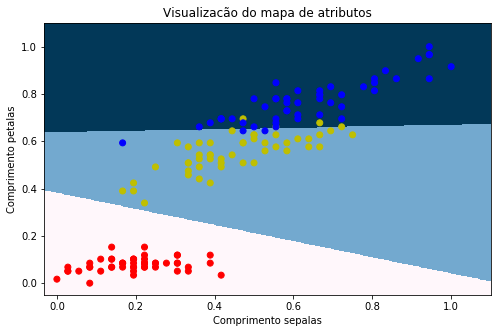

In [5]:
FSView(X_bias,Y,WT)